# Data Management

Here we will discuss how we can set up the system to retrieve, store, load, and prepare the data for analysis. **If user wanted to go straight to compiling the historical data then the first 3 code chunks should be run to have directory setup then search "Loading Data into Memory" section where the DATA loading and updating will occur**

## Setting Up Directory

We need to set up a couple directories

- Root directory which will be the directory that these tutorials are held
- Data directory 
- function directory

In [2]:
%ls

Backtesting Basics.ipynb                      README.md
Data_management.ipynb                         SPdates.R
Definitions and Formulas.ipynb                S.R
functions/                                    stockdata/
Intro to Strategies and Considerations.ipynb


In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
rootdir <- "/home/ck1/Documents/Projects/Python/QuantTrade/"
datadir <- "/home/ck1/Documents/Projects/Python/QuantTrade/stockdata/"
functiondir <- "/home/ck1/Documents/Projects/Python/QuantTrade/functions/"

## URL Query Building

It seems that the Yahoo Stock Service has been closed. So we will use the `quantmod` or `Quandl` R package to extract some data... let's see how this works. We need to set up a function that will download all historical data from start to end date.

In [4]:
%%R
# using Quandl
library(Quandl) # load the library
Quandl.api_key("NcNrBJn7i4MR4k3u8D1t") # This is the Quandl API_key that they give you
GOOGLqd <- Quandl("WIKI/GOOGL")
head(GOOGLqd) # this gets us from the most current to the latest information

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: xts

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: zoo

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)


        Date    Open    High     Low   Close  Volume Ex-Dividend Split Ratio
1 2018-01-18 1139.35 1140.59 1124.46 1135.97 1333633           0           1
2 2018-01-17 1136.36 1139.32 1123.49 1139.10 1353097           0           1
3 2018-01-16 1140.31 1148.88 1126.66 1130.70 1783881           0           1
4 2018-01-12 1110.10 1131.30 1108.01 1130.65 1914460           0           1
5 2018-01-11 1112.31 1114.85 1106.48 1111.88 1102461           0           1
6 2018-01-10 1107.00 1112.78 1103.98 1110.14 1027781           0           1
  Adj. Open Adj. High Adj. Low Adj. Close Adj. Volume
1   1139.35   1140.59  1124.46    1135.97     1333633
2   1136.36   1139.32  1123.49    1139.10     1353097
3   1140.31   1148.88  1126.66    1130.70     1783881
4   1110.10   1131.30  1108.01    1130.65     1914460
5   1112.31   1114.85  1106.48    1111.88     1102461
6   1107.00   1112.78  1103.98    1110.14     1027781


In [5]:
%%R
#using quantmod
library(quantmod)
getSymbols("GOOGL",src="yahoo") 
head(GOOGL)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: TTR

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Version 0.4-0 included new data defaults. See ?getSymbols.
Learn from a quantmod author: https://www.datacamp.com/courses/importing-and-managing-financial-data-in-r

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: ‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

  warnings.warn(x, RRuntimeWarning)
/u

           GOOGL.Open GOOGL.High GOOGL.Low GOOGL.Close GOOGL.Volume
2007-01-03   233.2332   238.5686  230.7858    234.0290     15397500
2007-01-04   234.7347   242.2172  234.4094    241.8719     15759400
2007-01-05   241.4915   243.9940  239.2943    243.8388     13730400
2007-01-08   244.0891   245.1802  241.3413    242.0320      9499200
2007-01-09   242.9680   244.3694  240.8408    242.9930     10752000
2007-01-10   242.4575   247.0220  241.2613    244.9750     11925000
           GOOGL.Adjusted
2007-01-03       234.0290
2007-01-04       241.8719
2007-01-05       243.8388
2007-01-08       242.0320
2007-01-09       242.9930
2007-01-10       244.9750


Now it seems that the quantmod does a much faster job in downloading the data... let's see if that is truly the case

In [6]:
%%R

# Here is a check on which function is faster in loading data
library(quantmod)
library(microbenchmark)
microbenchmark(
  getSymbols("GOOGL"),
  Quandl("WIKI/GOOGL"),
    times = 5
)

# faster way to load the above code is to vectorize the process and save accordingly


Unit: milliseconds
                 expr       min        lq      mean    median        uq
  getSymbols("GOOGL")  198.9669  211.2992  308.1043  336.8403  341.8566
 Quandl("WIKI/GOOGL") 1145.3463 1198.0748 1461.9387 1345.7439 1583.2712
       max neval cld
  451.5585     5  a 
 2037.2574     5   b


We can see that the quantmod function does a 4x times faster job... so we'll go with quantmod method :)

## Data Acquisition

Now we want to fetch a list of desired stocks... we will start with S&P 500. The `url` below has S&P 500 stock ticker stored as a list of character data. We will save it as an object `S`

In [7]:
%%R

url <- "http://trading.chrisconlan.com/SPstocks.csv"
S <- as.character(read.csv(url,header=FALSE)[,1])
setwd(rootdir)
dump(list="S","S.R")

Now we create a workflow that will download all of of the S&P data into the folder given that the ticker is in the S file if not then it will be inside the initial root directory.

In [8]:
%%R

# create function that will extract the closing price into dataframe
qmfunc <- function(sym, from="2000-01-01"){
  library(data.table)
  tryCatch(
    suppressWarnings(
    getSymbols(sym, from = from, env = globalenv())),
    error = function(e) NULL
  )
}
setwd(functiondir)
dump(list=c("qmfunc"), "qmfunc.R")

In [9]:
%%R

#load "invalid.R" file if available
invalid <- character(0)
setwd(rootdir)
if("invalid.R" %in% list.files()) source("invalid.R")

# find all symbols not in directory and not missing
setwd(datadir)
toload <- setdiff(S[!paste0(S, ".csv") %in% list.files()], invalid) # we only make a list for those to load

Now we can optimize the above code by using the `mclapply` function with the help of `parallel` package

In [11]:
%%R
library(parallel)

if(length(toload)!=0){
    
    # Function for extracting all of the stickers into the R environment
    mclapply(1:length(S),
         function(i) {
             qmfunc(S[[i]])
         })
    
    # Function to save the tickers that have been stored into csv file
    for(i in 1:length(intersect(S,ls()))){
        df <- data.frame(Date=index(get(intersect(S,ls())[i])), coredata(get(intersect(S,ls())[i])))
        names(df) <- c("Date","Open","High","Low","Close","Volume","Adj Close")
        fwrite(x = df, file = paste0(intersect(S,ls())[i],".csv"), row.names = FALSE)
    }
    
    # Function to include all tickers that haven't been downloaded
    for(i in 1:length(setdiff(S,intersect(S,ls())))){
        invalid <- c(invalid, setdiff(S,intersect(S,ls()))[i])
    }
    
}

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: data.table 1.10.4.2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   Documentation: ?data.table, example(data.table) and browseVignettes("data.table")

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   Release notes, videos and slides: http://r-datatable.com

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘data.table’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/

We've successfully saved all the stock data (of interest) into our folder and now need to remove objects from the environment except for path variables and functions

In [12]:
%%R
rm(list = setdiff(ls(), c("rootdir", "functiondir", "datadir", "yahoo","qmfunc")))
gc()

          used (Mb) gc trigger  (Mb) max used  (Mb)
Ncells 1219368 65.2    2164898 115.7  1928506 103.0
Vcells 1829998 14.0   17228173 131.5 21535134 164.4


## Loading Data Into Memory

Now that all the data file is stored in the `datadir`, we need to use the `data.table` library `fread()` function which has a faster speed compared to `read.csv`of the `base` package of `R`

In [6]:
%%R

setwd(datadir)
S <- sub(".csv", "", list.files())
library(data.table)
DATA <- list()
for(i in S) {
    suppressWarnings(
    DATA[[i]] <- fread(paste0(i, ".csv"), sep = ","))
    DATA[[i]] <- (DATA[[i]])[order(DATA[[i]][["Date"]], decreasing = FALSE)]
}

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: data.table 1.10.4.2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   Documentation: ?data.table, example(data.table) and browseVignettes("data.table")

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:   Release notes, videos and slides: http://r-datatable.com

  warnings.warn(x, RRuntimeWarning)


## Updating Data

Now we need to make sure the data is up to date by checking most recent date of each symbol. Yahoo finance API updates at about 8:00 pm EST after each trading day. This is 44 hours away from midnight the day before (24 + 20 = 44). But based on [This](https://stackoverflow.com/questions/22380475/when-yahoo-historical-quotes-gets-updated-daily) response, it seems that the final stocks that get updated are around 9:00 pm EST. Thus based on this we can check if the difference between the most recent time in our data and the current time is greater than 44 we can update the data. Since I am in Mountain Time, we need to set the `Sys.setenv(TZ='EST')`. Also we need to make sure that we are not updating on weekends. We basically do not want to unnecessary call the R function when it is in fact the weekend.

The below code takes so long... I would optimize it but there is another line of code below that will use Yahoo Query Language with a much faster update speed so... Probably shouldn't bother running the below code :)

In [14]:
#%%R
#
#Sys.setenv(TZ='EST')
#currentTime <- Sys.time()

#for(i in S){
 # # Store greatest date within DATA for symbol i
 # maxdate <- DATA[[i]][["Date"]][nrow(DATA[[i]])]
 # if(as.numeric(difftime(currentTime, maxdate, units = "hours")) >= 45){
    
 #   # Push the maxdate forward one day
 #   maxdate <- strptime(as.POSIXct(maxdate), "%Y-%m-%d") + 86400
 #   
 #   weekend <- sum(c("Saturday", "Sunday") %in% weekdays(c(as.POSIXct(maxdate), currentTime))) == 2
 #   
 #   span <- FALSE
 #   
 #   if( weekend ){
 #     span <- as.numeric(difftime(currentTime, maxdate, units = "hours"))
 #   }
 #   if(!weekend & !span){
 #     qmfunc(i, from = maxdate)
 #     
 #     if(i %in% ls()){
 #       if(all(!is.na(get(i))) & nrow(get(i)) > 0){
 #         get(i) <- get(i)[nrow(get(i)):1,]
 #         write.table(get(i), file = paste0(i,".csv"), sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)
 #         DATA[[i]] <- rbind(DATA[[i]], get(i))
 #       }
 #     }
 #   }
 # }
#}

Another way we can update the daily stock is to use the Yahoo Query Language (YQL), which is a MySQL-style API that allows for output of the data into XML, HTML, and JSON. Something to note is that Yahoo will throw an error if we request more than 15 tradying days at one time in batches of 101 stocks, so we will only request 1 day worth of 101 stocks (5 batches: 5 x 101 = 505). 

In [7]:
%%R

base <- "http://query.yahooapis.com/v1/public/yql?"
begQuery <- "q=select * from yahoo.finance.historicaldata where symbol in "
midQuery <- "( 'YHOO', 'GOOGL') "
endQuery <- "and startDate = '2014-01-01' and endDate = '2014-12-31'"
endParams <- "&diagnostics=true&env=store://datatables.org/alltableswithkeys"
urlstr <- paste0 (base, begQuery, midQuery, endQuery, endParams)
urlstr

[1] "http://query.yahooapis.com/v1/public/yql?q=select * from yahoo.finance.historicaldata where symbol in ( 'YHOO', 'GOOGL') and startDate = '2014-01-01' and endDate = '2014-12-31'&diagnostics=true&env=store://datatables.org/alltableswithkeys"


The URL string will result in an XML page if you copy paste it :) Now we need to use the `XML` package to parse through the data and update 

In [8]:
%%R

setwd(datadir)
library(XML)

currentTime <- Sys.time()

batchsize <- 101


# i in 1:5 for this example
for(i in 1:(ceiling(length(S) / batchsize)) ){
  
  midQuery <- " ("
  maxdate <- character(0)
  
  startIndex <- ((i - 1) * batchsize + 1) 
  endIndex <- min(i * batchsize, length(S))
  
  # find earliest date and build query
  for(s in S[startIndex:(endIndex - 1)]){
    maxdate <- c(maxdate, DATA[[s]][[1]][nrow(DATA[[s]])])
    midQuery <- paste0(midQuery, "'", s, "', ")
  }
  maxdate <- c(maxdate, DATA[[S[endIndex]]][[1]][nrow(DATA[[S[endIndex]]])])
  startDate <- max(maxdate)
  
  if( startDate <
      substr(strptime(substr(currentTime, 0, 10), "%Y-%m-%d") - 28 * 86400, 0, 10)){
    cat("Query is greater than 20 trading days. Download with csv method.")
    break
  }
  
  # Add a day (86400 seconds) to the earliest date to avoid duplicates
  startDate <- substr(as.character(strptime(startDate, "%Y-%m-%d") + 86400), 0, 10)
  endDate <- substr(currentTime, 0, 10)
  
  # Yahoo! updates at 4:15 EST at earliest, check if it is part 4:15 day after last
  isUpdated <- as.numeric(difftime(currentTime, startDate, units = "hours")) >= 45
  
  # If both days fall in the same weekend, we won't attemp tto update
  weekend <- sum(c("Saturday", "Sunday") %in% weekdays(c(strptime(endDate, "%Y-%m-%d"), c(strptime(startDate, "%Y-%m-%d"))))) == 2 
  
  span <- FALSE
  if( weekend ){
    span <- as.numeric(difftime(currentTime, startDate, units = "hours")) < 48
  }
  if( startDate <= endDate & !weekend & !span & isUpdated){
    # Given the condition that there is updatable data
    base <- "http://query.yahooapis.com/v1/public/yql?"
    begQuery <- "q=select * from yahoo.finance.historicaldata where symbol in "
    midQuery <- paste0(midQuery, "'", S[min(i * batchsize, length(S))], "') ")
    endQuery <- paste0("and startDate = '", startDate, "' and endDate = '", endDate, "'")
    endParams <- "&diagnostics=true&env=store://datatables.org/alltableswithkeys"
    
    urlstr <- paste0(base, begQuery, midQuery, endQuery, endParams)
    
    # Fetch data and arrange in XML tree
    
    doc <- xmlParse(urlstr)
    
    # Below lines rely on XPath and quirks of S4 objects in XML package in R. 
    
    df <- getNodeSet(doc, c("//query/results/quote"),
                     fun = function(v) xpathSApply(v,
                                                   c("./Date",
                                                     "./Open",
                                                     "./High",
                                                     "./Low",
                                                     "./Close",
                                                     "./Volume",
                                                     "./Adj_Close"),
                                                   xmlValue))
    
    # If the URL did find data, we organize and update
    if(length(df) != 0){
      #we get attributes from the same tree, which happen to be dates we need
      symbols <- unname(sapply(
        getNodeSet(doc, c("//query/results/quote")), xmlAttrs))
      
      df <- cbind(symbols, data.frame(t(data.frame(df, stringAsFactors = FALSE)),
                                      stringAsFactors = FALSE, row.names = NULL))
      
      names(df) <- c("Symbol","Date","Open","High","Low","Close","Volume","Adj Close")
      
      df[,3:8] <- lapply(df[,3:8], as.numeric)
      df <- df[order(df[,1], decreasing = FALSE),]
      
      sym <- as.character(unique(df$Symbol))
      
      for(s in sym){
        
        temp <- df[df$Symbol == s, 2:8]
        temp <- temp[order(temp[,1], decreasing = FALSE),]
        
        startDate <- DATA[[s]][["Date"]][nrow(DATA[[s]])]
        
        DATA[[s]] <- DATA[[s]][order(DATA[[s]][[1]], decreasing = FALSE)]
        DATA[[s]] <- rbind(DATA[[s]], temp[temp$Date > startDate, ])
        write.table(DATA[[s]][DATA[[s]][["Date"]] > startDate],
                    file = paste0(s, ".csv"), sep = ",",
                    row.names = FALSE, col.names = FALSE, append = TRUE)
      }
    }
  }
}

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘XML’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:tools’:

    toHTML


  warnings.warn(x, RRuntimeWarning)


## Organizing as Date-Uniform `zoo` Object

Now we want our platform to pull data and run strategies for many symbols in different countries thus we need to make sure the dates line up and account for days off in each respective country.

In [9]:
%%R
head(DATA[["AAP"]])

         Date     Open     High      Low    Close Volume Adj Close
1: 2001-11-29 13.38667 14.46667 13.36000 13.88000 371100  13.25355
2: 2001-11-30 13.88000 14.26667 13.88000 14.26667 165300  13.62276
3: 2001-12-03 14.23333 14.23333 13.78333 13.78333 127500  13.16124
4: 2001-12-04 13.78333 13.78333 13.23333 13.23333  95400  12.63607
5: 2001-12-05 13.43333 14.78333 13.43333 14.66667 598200  14.00470
6: 2001-12-06 14.73333 14.73333 14.57000 14.57333 157200  13.91559


In [10]:
%%R

library(zoo)

# compute date template as column of date.frame for merging
# considers date are strings in YYY-MM-DD format

datetemp <- sort(unique(unlist(sapply(DATA, function(v) v[["Date"]]))))
datetemp <- data.frame(datetemp, stringsAsFactors = FALSE)
names(datetemp) <- "Date"
                                      
# Double chck the data is unique and in ascending-date order
DATA <- lapply(DATA, function(v) unique(v[order(v$Date),]))

# Create 6 new objects that will hold re-organized data
DATA[["Open"]] <- DATA[["High"]] <- DATA[["Low"]] <- DATA[["Close"]] <- DATA[["Adj Close"]] <- DATA[["Volume"]] <- datetemp

# This loop will sequentially append new columns of each symbol to appropriate Open, High, Low, etc obj
    
for(s in S){
    for(i in rev(c("Open","High","Low","Close","Adj Close","Volume"))){
        temp <- data.frame(cbind(DATA[[s]][["Date"]], DATA[[s]][[i]]),
                          stringsAsFactors = FALSE)
        names(temp) <- c("Date", s)
        temp[,2] <- as.numeric(temp[,2])
        
        if(!any(!DATA[[i]][["Date"]][(nrow(DATA[[i]]) - nrow(temp)+1):nrow(DATA[[i]])] == temp[,1])){
            temp <- rbind(t(matrix(nrow = 2, ncol = nrow(DATA[[i]]) - nrow(temp), dimnames = list(names(temp)))), temp)
            DATA[[i]] <- cbind(DATA[[i]], temp[,2])
        } else {
            DATA[[i]]
            DATA[[i]] <- merge(DATA[[i]], temp, all.v = TRUE, by = "Date")
        }
        
        names(DATA[[i]]) <- c(names(DATA[[i]])[-(ncol(DATA[[i]]))], s)
    }
    DATA[[s]] <- NULL
    
    # Update user on progress
    if( which(S == s) %% 25 ==0){
        cat(paste0(round(100 * which(S == s) / length(S), 1), "% Complete\n"))
    }
}
# Declare them as zoo objects for use with time-series functions
DATA <- lapply(DATA, function(v) zoo(v[,2:ncol(v)], strptime(v[,1], "%Y-%m-%d")))
# Remove extra vars
rm(list = setdiff(ls(), c("DATA", "datadir", "functiondir", "rootdir")))

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)


5.3% Complete
10.7% Complete
16% Complete
21.3% Complete
26.7% Complete
32% Complete
37.3% Complete
42.6% Complete
48% Complete
53.3% Complete
58.6% Complete
64% Complete
69.3% Complete
74.6% Complete
80% Complete
85.3% Complete
90.6% Complete
95.9% Complete


Time to check the data

In [11]:
%%R
str(DATA)

List of 6
 $ Volume   :‘zoo’ series from 2000-01-03 to 2018-01-17
  Data: num [1:4539, 1:469] 4674300 4765000 5758600 2534400 2819600 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:469] "A" "AA" "AAL" "AAP" ...
  Index:  POSIXlt[1:4539], format: "2000-01-03" "2000-01-04" ...
 $ Adj Close:‘zoo’ series from 2000-01-03 to 2018-01-17
  Data: num [1:4539, 1:469] 45.7 42.2 39.6 38.1 41.3 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:469] "A" "AA" "AAL" "AAP" ...
  Index:  POSIXlt[1:4539], format: "2000-01-03" "2000-01-04" ...
 $ Close    :‘zoo’ series from 2000-01-03 to 2018-01-17
  Data: num [1:4539, 1:469] 51.5 47.6 44.6 42.9 46.5 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:469] "A" "AA" "AAL" "AAP" ...
  Index:  POSIXlt[1:4539], format: "2000-01-03" "2000-01-04" ...
 $ Low      :‘zoo’ series from 2000-01-03 to 2018-01-17
  Data: num [1:4539, 1:469] 48.2 46.3 43.1 41.6 42.2 ...
  ..- attr(*, "dimnames")=Li

# Data Preparation

Now that we have a list of 6 zoo objects (i.e. relevant measures of our stock) we need to focus our efforts on these things:
- Clean data for optimizing analysis
- Compute new dataset for analysis

##  Handling NA Values

### NA vs NaN in R

$ \frac{a}{0} = Inf, \frac{0}{0} = NaN, \frac{-a}{0} = -Inf$ 

### IPOs and Additions to S&P 500

Let's take a look at the stock ticker `KORS` they should have some NA values because they don't quite have the Pre-IPO data. The S&P500 requires that companies have a minimum of $5.3 billion minimum market capitalization therefore `KORS` do not have any data pre-S&P500.

In [12]:
%%R

library(dplyr)

subset(DATA$Open$KORS, index(DATA$Open) >= "2011-12-11" & index(DATA$Open) <= "2011-12-19")

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:data.table’:

    between, first, last


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


2011-12-12 2011-12-13 2011-12-14 2011-12-15 2011-12-16 2011-12-19 
        NA         NA         NA      25.00      24.45      24.50 


Now we need to get rid of the Pre-S&P Data with regards to having them just be `NA` values. any time before 1/1/2000 will be regarded as such.

In [13]:
%%R

setwd(rootdir)
if("SPdates.R" %in% list.files()){
    source("SPdates.R")
} else {
    url <- "http://trading.chrisconlan.com/SPdates.csv"
    S <- read.csv(url, header = FALSE, stringsAsFactors = FALSE)
    dump(list = "S", "SPdates.R")
} 
names(S) <- c("Symbol", "Date")
S$Date <- strptime(S$Date, "%m/%d/%Y")
for(s in names(DATA[["Close"]])) {
    for(i in c("Open", "High", "Low", "Close","Adj Close","Volume")){
        Sindex <- which(S[,1] ==s)
        if(S[Sindex, "Date"] != "1900-01-01 EST" & S[Sindex, "Date"] >="2000-01-01 EST"){
            DATA[[i]][index(DATA[[i]]) <= S[Sindex, "Date"], s] <- NA
        }
    }
}

## Merging to the Uniform Data Template

Since there will be many stocks traded internationally, there would be missing values in nonoverlapping trading days (i.e. a friday in U.S. would be a saturday in Japan thus there would be NA in Japane for that day). So in order to address this we need to go through these:
- Forward replacement (in statistics this would be a carry last observation forward)
- Linearly smoothed replacement (i.e. linear line from previous to current)
- Volume-weighted smoothed replacement (i.e. two nearest points in linearly smoothed replacement and weights by volume of nearest non-missing days)
- Do nothing

Let's use the 10-day period of `KORS` where we pretend we need to fill in prices on Thanksgiving 2016 and the following Black Friday weekend.

In [14]:
%%R

# create temporary data
temp <- c(DATA[["Close"]][index(DATA[["Close"]]) %in% c("2016-11-21", "2016-11-22","2016-11-23"), "KORS"],
         zoo(NA, order.by = strptime("2016-11-24", "%Y-%m-%d")),
         DATA[["Close"]][index(DATA[["Close"]]) %in% c("2016-11-25"), "KORS"],
         zoo(NA, order.by = strptime(c("2016-11-26", "2016-11-27"), "%Y-%m-%d")),
          DATA[["Close"]][index(DATA[["Close"]]) %in% c("2016-11-28","2016-11-29","2016-11-30"), "KORS"])

##  Forward Replacement (aka last observation carried forward)

Forward replacement function `rollapply()` will be replacing a `NA` value with the most recent non-`NA` value. 

‘zoo’ series from 2016-11-21 to 2016-11-30
  Data: num [1:10] 48.1 48.3 48.6 NA 48.9 ...
  Index:  POSIXlt[1:10], format: "2016-11-21" "2016-11-22" "2016-11-23" "2016-11-24" "2016-11-25" ...


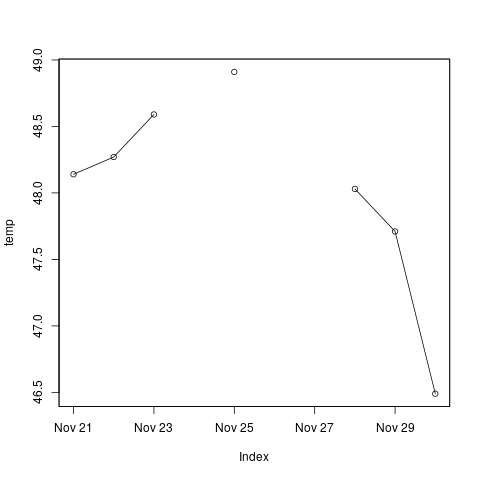

In [15]:
%%R
str(temp)
plot(temp, type = c("l"))
points(temp)

Just based on the plot there is a huge chunk that is missing...

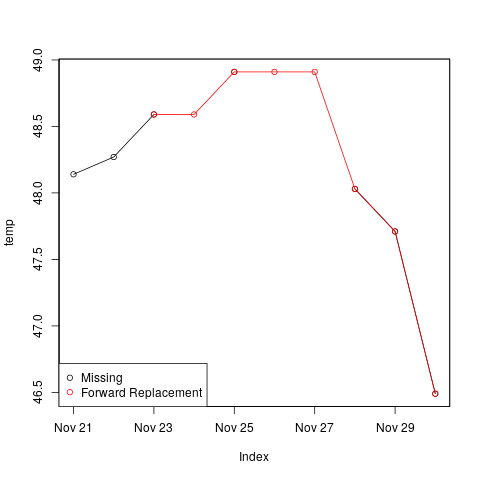

In [16]:
%%R

# we define the forward function here
forwardfun <- function(v, n){
    if(is.na(v[n])){
        return(v[max(which(!is.na(v)))])
    } else {
        return(v[n])
    }
}
maxconsec <- 3

forwardrep <- rollapply(temp,
                       width = maxconsec,
                       FUN = forwardfun,
                       n = maxconsec,
                       by.column = TRUE,
                       align = "right")
plot(temp, type = c("l"))
points(temp)
lines(forwardrep, type = c("l"), col = "red")
points(forwardrep, col = "red")
legend("bottomleft", pch = c(1,1), col = c("black","red"), legend = c("Missing","Forward Replacement"))

## Linearly Smoothed Replacement

In a linear smoothed replacement (basically a linear interpolation) scheme, the `maxconsec` variable must be odd and greater than the max number of consecutive NAs plus two. Since in the top we have 2 consecutive NAs as the max, 2+2+1 = 5. 

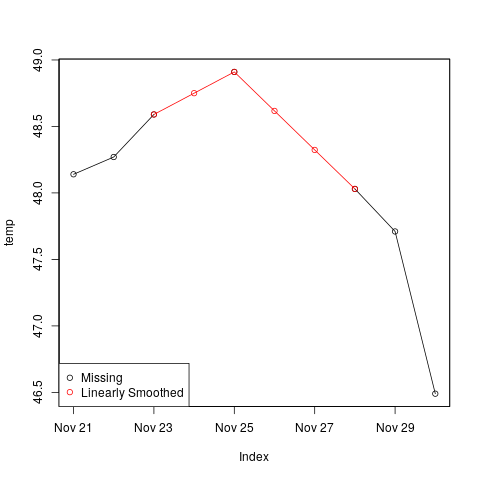

In [33]:
%%R
# linear smoothed replacement function

linearfun <- function(v, n){
    m <- (n + 1)/2
    if(is.na(v[m])){
        a <- max(which(!is.na(v) & seq(1:n) < m))
        b <- min(which(!is.na(v) & seq(1:n) > m))
        return(((b-m)/(b-a)) * v[a] + ((m-a)/(b-a)) * v[b])
    } else {
        return(v[m])
    }
}

maxconsec <- 5
linearrep <- rollapply(temp, width = maxconsec, FUN = linearfun, n = maxconsec, by.column = TRUE, align = "center")

plot(temp, type = c("l"))
points(temp)
lines(linearrep, type = c("l"), col = "red")
points(linearrep, col = "red")
legend("bottomleft", pch = c(1,1), col = c("black","red"), legend = c("Missing","Linearly Smoothed"))

## Volume-Weighted Smoothed Replacement

In addition to the linear smoothing based on the value according to the `maxconsec`, weighting the values of the previous and post `NA` values according to the volume introduces another complexity that may better represent the `NA` values.

In [53]:
%%R
voltemp <- c(DATA[["Volume"]][index(DATA[["Close"]]) %in% c(index(temp)[1:3]), "KORS"],
            zoo(NA, order.by = index(temp)[4]),
            DATA[["Volume"]][index(DATA[["Close"]]) %in% c(index(temp)[5]), "KORS"],
            zoo(NA, order.by = index(temp)[6:7]),
            DATA[["Volume"]][index(DATA[["Close"]]) %in% c("2016-11-28","2016-11-29","2016-11-30"), "KORS"])

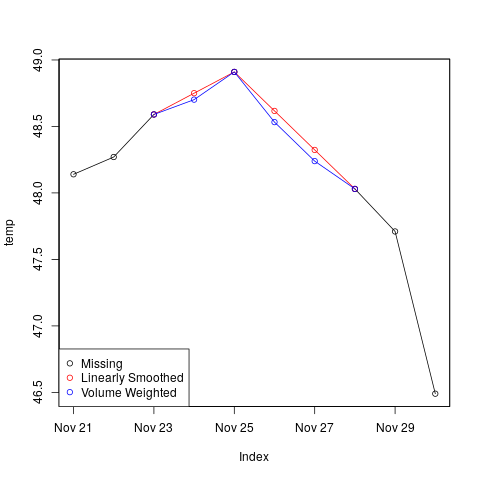

In [63]:
%%R
volfun <- function(v, n, vol) {
    m <- (n + 1)/2
    if(is.na(v[m])){
        a <- max(which(!is.na(v) & seq(1:n) < m))
        b <- min(which(!is.na(v) & seq(1:n) > m))
        return(((v[a] + ((m-a-1)/(b-a)) * (v[b] - v[a])) * vol[a] + 
                (v[a] + ((m-a+1)/(b-a)) * (v[b] - v[a])) * vol[b]) /
                (vol[a] + vol[b]))
    } else {
        return(v[m])
    }
}
maxconsec <- 5
volrep <- rollapply(cbind(temp, voltemp), width = maxconsec, FUN = function(v) volfun(v[,1], n = maxconsec, v[,2]),
                    by.column = FALSE, align = "center")

plot(temp, type = c("l"))
points(temp)
lines(linearrep, type = c("l"), col = "red")
points(linearrep, col = "red")
lines(volrep, type = c("l"), col = "blue")
points(volrep, col = "blue")
legend("bottomleft", pch = c(1,1,1), col = c("black","red","blue"), legend = c("Missing","Linearly Smoothed", "Volume Weighted"))

## 